# SSD MVTec Anomaly Detection Analysis

This notebook provides comprehensive analysis of the SSD model trained on MVTec dataset, including:
- Dataset statistics
- Training configuration and results
- Model performance metrics
- Qualitative inspection with visualizations


In [11]:
%matplotlib inline

from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision.models.detection import ssd300_vgg16
from torchvision.models.detection.ssd import SSDClassificationHead
from PIL import Image
import numpy as np
import cv2

sns.set_theme(style="whitegrid")


In [12]:
# Configuration - UPDATE THESE PATHS
BASE_DIR = Path("/Users/vantrinh/Work/python/yolo")
DATASET_DIR = BASE_DIR / "datasets/ssd_mvtec_bottle"
MODEL_DIR = BASE_DIR / "model_ssd/ssd_mvtec_20251120_215313"  # UPDATE THIS
MODEL_PATH = MODEL_DIR / "best.pt"
INFERENCE_DIR = MODEL_DIR / "inference_val"


📊 DATASET COMPARISON

✓ Original Dataset:
   Train images: 66
   Val images:   17
   Total:        83

✓ Augmented Dataset (factor: 3):
   Train images: 264 (original: 66, augmented: 198)
   Val images:   68 (original: 17, augmented: 51)
   Total:        332

✓ Used for training: Original dataset




,Dataset,Train,Val,Total
0,Original,66,17,83
1,Augmented,264,68,332


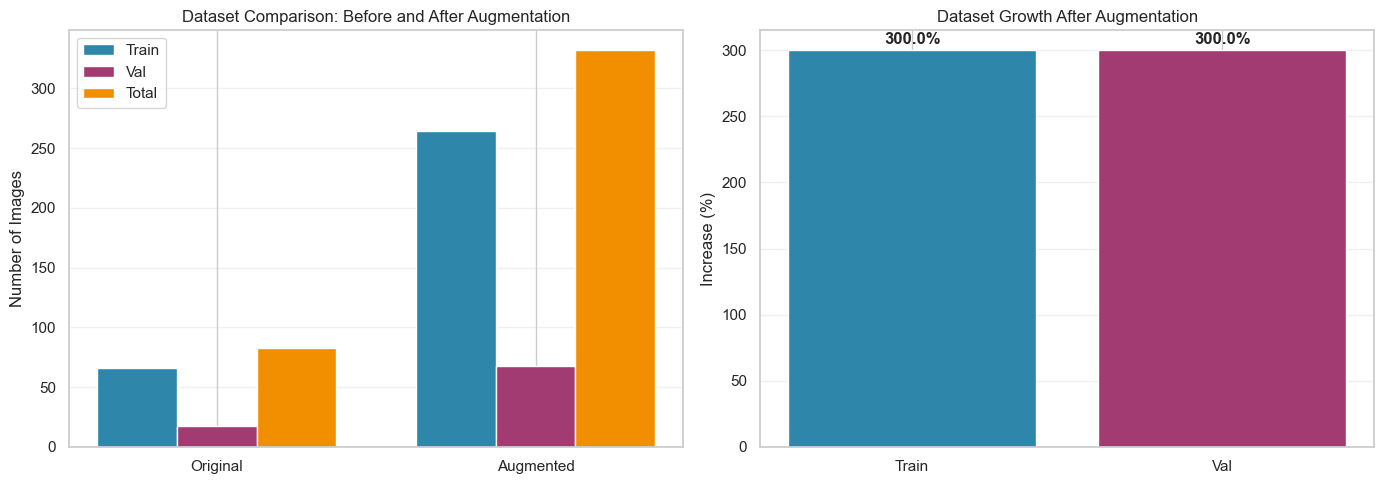

In [13]:
# Check if we're using augmented dataset
augmented_dataset_dir = BASE_DIR / "datasets/ssd_mvtec_bottle_augmented"
original_dataset_dir = BASE_DIR / "datasets/ssd_mvtec_bottle"

# Determine which dataset was used for training
if DATASET_DIR.exists() and "augmented" in str(DATASET_DIR):
    using_augmented = True
    aug_info_path = DATASET_DIR / "augmentation_info.json"
else:
    using_augmented = False
    # Check if augmented dataset exists even if not used
    if augmented_dataset_dir.exists():
        aug_info_path = augmented_dataset_dir / "augmentation_info.json"
    else:
        aug_info_path = None

print("📊 DATASET COMPARISON")
print("="*60)

# Load original dataset info
orig_info_path = original_dataset_dir / "dataset_info.json"
if orig_info_path.exists():
    with open(orig_info_path, 'r') as f:
        orig_info = json.load(f)
    
    print("\n✓ Original Dataset:")
    print(f"   Train images: {orig_info.get('train_images', 0)}")
    print(f"   Val images:   {orig_info.get('val_images', 0)}")
    print(f"   Total:        {orig_info.get('train_images', 0) + orig_info.get('val_images', 0)}")
else:
    print("\n⚠️  Original dataset info not found")
    orig_info = None

# Load augmented dataset info
if aug_info_path and aug_info_path.exists():
    with open(aug_info_path, 'r') as f:
        aug_info = json.load(f)
    
    stats = aug_info.get('stats', {})
    train_stats = stats.get('train', {})
    val_stats = stats.get('val', {})
    
    print(f"\n✓ Augmented Dataset (factor: {aug_info.get('augmentation_factor', 'N/A')}):")
    print(f"   Train images: {train_stats.get('total', 0)} (original: {train_stats.get('original', 0)}, augmented: {train_stats.get('augmented', 0)})")
    print(f"   Val images:   {val_stats.get('total', 0)} (original: {val_stats.get('original', 0)}, augmented: {val_stats.get('augmented', 0)})")
    print(f"   Total:        {train_stats.get('total', 0) + val_stats.get('total', 0)}")
    
    print(f"\n✓ Used for training: {'Augmented' if using_augmented else 'Original'} dataset")
    
    # Create comparison DataFrame
    comparison_data = []
    
    if orig_info:
        comparison_data.append({
            "Dataset": "Original",
            "Train": orig_info.get('train_images', 0),
            "Val": orig_info.get('val_images', 0),
            "Total": orig_info.get('train_images', 0) + orig_info.get('val_images', 0)
        })
    
    comparison_data.append({
        "Dataset": "Augmented",
        "Train": train_stats.get('total', 0),
        "Val": val_stats.get('total', 0),
        "Total": train_stats.get('total', 0) + val_stats.get('total', 0)
    })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n")
    display(comparison_df)
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart comparison
    x = np.arange(len(comparison_data))
    width = 0.25
    
    axes[0].bar(x - width, [d['Train'] for d in comparison_data], width, label='Train', color='#2E86AB')
    axes[0].bar(x, [d['Val'] for d in comparison_data], width, label='Val', color='#A23B72')
    axes[0].bar(x + width, [d['Total'] for d in comparison_data], width, label='Total', color='#F18F01')
    
    axes[0].set_ylabel('Number of Images')
    axes[0].set_title('Dataset Comparison: Before and After Augmentation')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([d['Dataset'] for d in comparison_data])
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Augmentation breakdown
    if orig_info:
        train_increase = ((train_stats.get('total', 0) - orig_info.get('train_images', 0)) / orig_info.get('train_images', 1)) * 100
        val_increase = ((val_stats.get('total', 0) - orig_info.get('val_images', 0)) / orig_info.get('val_images', 1)) * 100
        
        axes[1].bar(['Train', 'Val'], [train_increase, val_increase], color=['#2E86AB', '#A23B72'])
        axes[1].set_ylabel('Increase (%)')
        axes[1].set_title('Dataset Growth After Augmentation')
        axes[1].grid(axis='y', alpha=0.3)
        
        for i, (label, val) in enumerate(zip(['Train', 'Val'], [train_increase, val_increase])):
            axes[1].text(i, val + 5, f'{val:.1f}%', ha='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("\n⚠️  Augmented dataset not found")
    print("Run augmentation first:")
    print(f"python augment_ssd_dataset.py --dataset_dir {original_dataset_dir}")

print("="*60)


In [14]:
# Load evaluation metrics
metrics_path = INFERENCE_DIR / "metrics.json"

if metrics_path.exists():
    with open(metrics_path, 'r') as f:
        metrics = json.load(f)
    
    print("✓ Evaluation metrics loaded\n")
    
    # Display overall metrics
    print("="*60)
    print("OVERALL METRICS")
    print("="*60)
    print(f"Accuracy : {metrics.get('accuracy', 0)*100:>6.2f}%")
    print(f"Precision: {metrics.get('precision', 0)*100:>6.2f}%")
    print(f"Recall   : {metrics.get('recall', 0)*100:>6.2f}%")
    print(f"F1-Score : {metrics.get('f1_score', 0)*100:>6.2f}%")
    print(f"Defect detection rate: {metrics.get('defect_detection_rate', 0)*100:>6.2f}%")
    print(f"Composite: {metrics.get('composite_score', 0)*100:>6.2f}%")
    print(f"Confidence: {metrics.get('confidence', 0)*100:>6.2f}%")
    print("="*60)
    
    # Model Scorecard
    scorecard_df = pd.DataFrame([
        {"Metric": "Accuracy", "Value": f"{metrics.get('accuracy', 0)*100:.2f}%"},
        {"Metric": "Precision", "Value": f"{metrics.get('precision', 0)*100:.2f}%"},
        {"Metric": "Recall", "Value": f"{metrics.get('recall', 0)*100:.2f}%"},
        {"Metric": "F1-Score", "Value": f"{metrics.get('f1_score', 0)*100:.2f}%"},
        {"Metric": "Defect detection rate", "Value": f"{metrics.get('defect_detection_rate', 0)*100:.2f}%"},
        {"Metric": "Composite Score", "Value": f"{metrics.get('composite_score', 0)*100:.2f}%"},
        {"Metric": "Confidence", "Value": f"{metrics.get('confidence', 0)*100:.2f}%"},
    ])
    
    print("\n📊 Model Scorecard:")
    display(scorecard_df)
    
    # Confusion Matrix
    confusion_df = pd.DataFrame([
        {"Metric": "TP (Defect detected)", "Count": metrics.get('tp_defect', 0)},
        {"Metric": "FP (False defect)", "Count": metrics.get('fp_defect', 0)},
        {"Metric": "TN (Good correct)", "Count": metrics.get('tn_good', 0)},
        {"Metric": "FN (Defect missed)", "Count": metrics.get('fn_defect', 0)},
        {"Metric": "Total images", "Count": metrics.get('total_images', 0)},
    ])
    
    print("\n📈 Confusion Matrix:")
    display(confusion_df)
    
else:
    print(f"⚠️ Metrics not found at {metrics_path}")
    print("Please run inference first:")


✓ Evaluation metrics loaded

OVERALL METRICS
Accuracy :  88.24%
Precision: 100.00%
Recall   :  84.62%
F1-Score :  91.67%
Defect detection rate:  84.62%
Composite:  90.19%
Confidence:  85.81%

📊 Model Scorecard:


,Metric,Value
0,Accuracy,88.24%
1,Precision,100.00%
2,Recall,84.62%
3,F1-Score,91.67%
4,Defect detection rate,84.62%
5,Composite Score,90.19%
6,Confidence,85.81%



📈 Confusion Matrix:


,Metric,Count
0,TP (Defect detected),44
1,FP (False defect),0
2,TN (Good correct),16
3,FN (Defect missed),8
4,Total images,68


Testing rotation robustness...


Testing: 000068.jpg (GT: Defect)
    0°: Pred=DEFECT, Detections=1, Match=✓
   90°: Pred=DEFECT, Detections=1, Match=✓
  180°: Pred=DEFECT, Detections=1, Match=✓
  270°: Pred=  GOOD, Detections=0, Match=✗


/var/folders/hp/h6mhwhq53tq97lbfcl3gjbg00000gn/T/ipykernel_80471/487044518.py:70: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/hp/h6mhwhq53tq97lbfcl3gjbg00000gn/T/ipykernel_80471/487044518.py:70: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
/Users/vantrinh/Work/python/yolo/venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/vantrinh/Work/python/yolo/venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


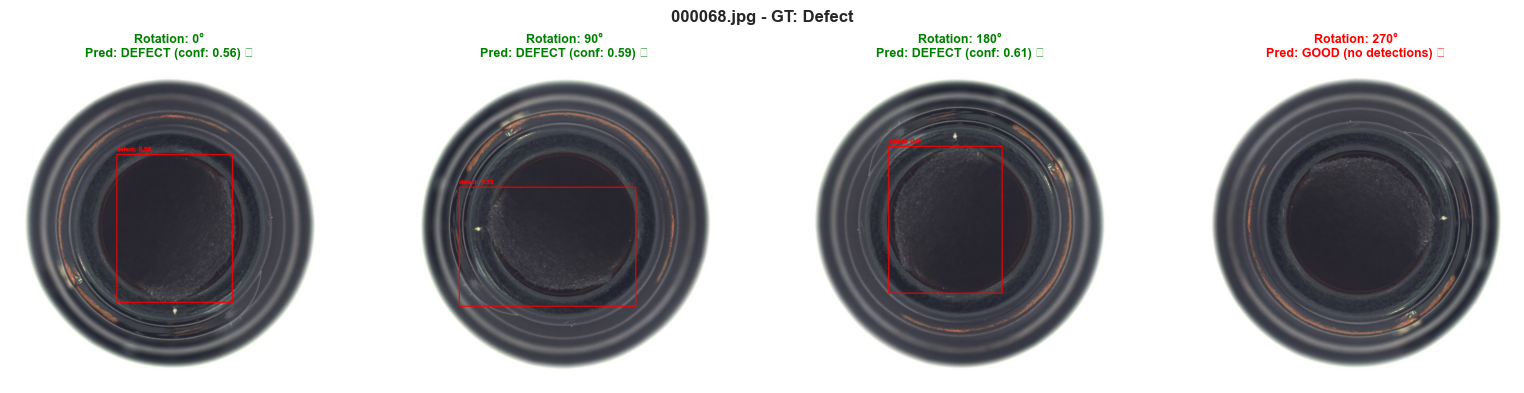


Rotation Test Summary:


,Rotation,Prediction,Detections,Avg Confidence,Match
0,0°,DEFECT,1,0.56,✓
1,90°,DEFECT,1,0.59,✓
2,180°,DEFECT,1,0.61,✓
3,270°,GOOD,0,N/A,✗



Testing: 000067.jpg (GT: Good)
    0°: Pred=  GOOD, Detections=1, Match=✓
   90°: Pred=  GOOD, Detections=1, Match=✓
  180°: Pred=  GOOD, Detections=1, Match=✓
  270°: Pred=  GOOD, Detections=1, Match=✓


/var/folders/hp/h6mhwhq53tq97lbfcl3gjbg00000gn/T/ipykernel_80471/487044518.py:70: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/Users/vantrinh/Work/python/yolo/venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


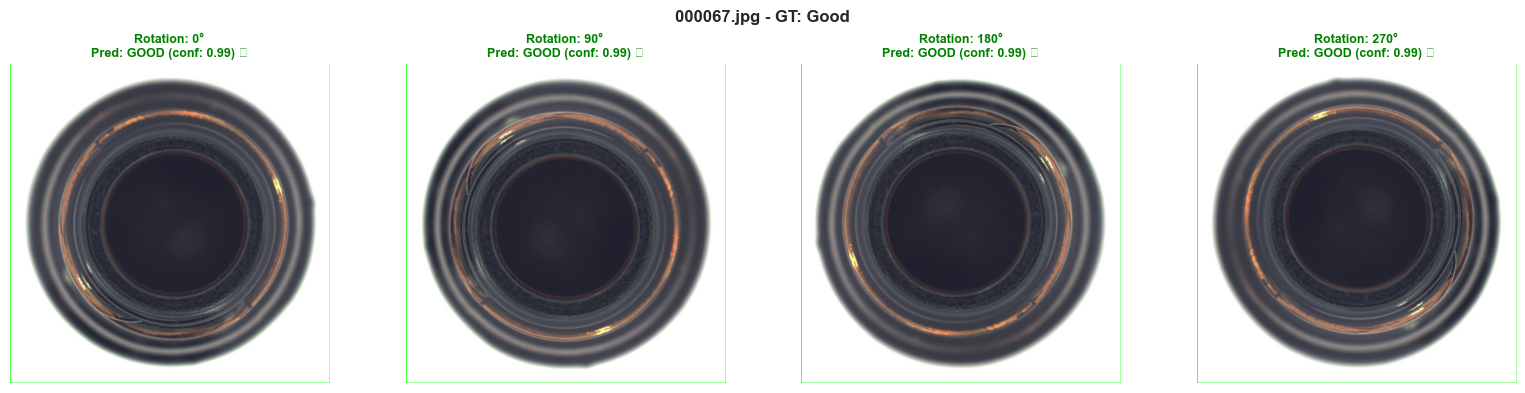


Rotation Test Summary:


,Rotation,Prediction,Detections,Avg Confidence,Match
0,0°,GOOD,1,0.99,✓
1,90°,GOOD,1,0.99,✓
2,180°,GOOD,1,0.99,✓
3,270°,GOOD,1,0.99,✓



✓ Rotation test completed


In [15]:
# Test rotation on first image of each type
test_images = [selected_defect[0], selected_good[0]]
test_labels = ['Defect', 'Good']

rotation_angles = {
    '0°': None,
    '90°': cv2.ROTATE_90_CLOCKWISE,
    '180°': cv2.ROTATE_180,
    '270°': cv2.ROTATE_90_COUNTERCLOCKWISE
}

print("Testing rotation robustness...\n")

for img_info, gt_label in zip(test_images, test_labels):
    img_path = val_images_dir / img_info['file_name']
    original_image = cv2.imread(str(img_path))
    
    print(f"\n{'='*60}")
    print(f"Testing: {img_info['file_name']} (GT: {gt_label})")
    print(f"{'='*60}")
    
    # Create subplot for this image
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    results_summary = []
    
    for idx, (angle, rotation_code) in enumerate(rotation_angles.items()):
        # Rotate image
        if rotation_code is None:
            rotated_image = original_image.copy()
        else:
            rotated_image = cv2.rotate(original_image, rotation_code)
        
        # Run inference
        boxes, labels, scores = run_inference(model, rotated_image, device, conf_threshold=0.5)
        
        # Draw predictions
        annotated_image = draw_predictions(rotated_image, boxes, labels, scores)
        
        # Get verdict
        verdict = get_verdict(boxes, labels)
        match = "✓" if gt_label.upper() == verdict else "✗"
        
        # Display
        axes[idx].imshow(annotated_image)
        
        # Create title
        if len(boxes) > 0:
            avg_conf = np.mean(scores)
            title = f"Rotation: {angle}\nPred: {verdict} (conf: {avg_conf:.2f}) {match}"
        else:
            title = f"Rotation: {angle}\nPred: {verdict} (no detections) {match}"
        
        color = 'green' if match == "✓" else 'red'
        axes[idx].set_title(title, fontsize=9, color=color, fontweight='bold')
        axes[idx].axis('off')
        
        # Store result
        results_summary.append({
            'Rotation': angle,
            'Prediction': verdict,
            'Detections': len(boxes),
            'Avg Confidence': f"{np.mean(scores):.2f}" if len(scores) > 0 else "N/A",
            'Match': match
        })
        
        print(f"  {angle:>4s}: Pred={verdict:>6s}, Detections={len(boxes)}, Match={match}")
    
    plt.suptitle(f"{img_info['file_name']} - GT: {gt_label}", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Display summary table
    summary_df = pd.DataFrame(results_summary)
    print("\nRotation Test Summary:")
    display(summary_df)

print("\n" + "="*60)
print("✓ Rotation test completed")
print("="*60)
